In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import copy
import nugget
from conflictfree.grad_operator import ConFIG_update
import time
from scipy.stats import gaussian_kde
from IPython.display import clear_output
import matplotlib.pyplot as plt
import importlib
# importlib.reload(nugget)



In [ ]:
geometry = nugget.utils.geometries.EvanescentString(
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        dim=3,
        domain_size=2.0,
        n_strings=500,
        points_per_string=10,
        optimize_z=False,
        starting_weight=0.6,   
)

In [37]:
conflict_free = False
loss_function = nugget.utils.losses.WeightedSNRLoss(
        device=geometry.device,
        domain_size=geometry.domain_size,
        repulsion_weight=0,
        boundary_weight=0,
        string_repulsion_weight=0.01,
        max_local_rad=0.08,
        path_repulsion_weight=0,
        z_repulsion_weight=0,
        eva_weight=0.01,
        eva_boundary_weight=0,
        eva_binary_weight=0.000,
        eva_string_num_weight=0.008,
        eva_min_num_strings=50,
        min_dist=0.001,
        snr_weight=50,
        signal_scale=1,
        background_scale=10,
        no_background=False,
        conflict_free=conflict_free,
)

In [47]:
importlib.reload(nugget.utils.vis_tools)
gif_dir = './gif_temp'
visualizer = nugget.utils.vis_tools.Visualizer(
                                device=geometry.device,
                                dim=geometry.dim, 
                                domain_size=geometry.domain_size,
                                gif_temp_dir=gif_dir
        )

In [48]:
geom_dict = geometry.initialize_points()
loss_history = []
snr_history = []
optimizers = {}
schedulers = {}
num_iterations = 600
batch_size = 2

string_xy = geom_dict.get('string_xy')
string_weights = geom_dict.get('string_weights')

# print(f"Optimizing string_xy with shape {string_xy.shape}")
# string_xy.requires_grad_(True)
# geom_dict['string_xy'] = string_xy
# xy_optimizer = torch.optim.Adam([string_xy], lr=self.xy_learning_rate)
# optimizers['string_xy'] = xy_optimizer

# xy_scheduler = nugget.utils.schedulers.create_scheduler(
#     xy_optimizer, num_iterations,
#     'exp', {'gamma': 0.95}
# )

# schedulers['string_xy'] = xy_scheduler

print(f"Optimizing string_weights with shape {string_weights.shape}")
string_weights.requires_grad_(True)
geom_dict['string_weights'] = string_weights
weights_optimizer = torch.optim.Adam([string_weights], lr=0.1)
optimizers['string_weights'] = weights_optimizer

# weights_scheduler = nugget.utils.schedulers.create_scheduler(
#     weights_optimizer, num_iterations,
#     'exp', {'gamma': 0.95}
# )

# schedulers['string_weights'] = weights_scheduler


Optimizing string_weights with shape torch.Size([500])


In [14]:
# can run this cell once and reuse surrogate model and precomputed SNR
surrogate_model = nugget.utils.surrogates.SkewedGaussian(
                                device=geometry.device,
                                dim=geometry.dim, 
                                domain_size=geometry.domain_size
                                )

def test_signal_func(position):
    """Example signal function for testing."""
    return torch.ones(position.shape[0])

def test_background_func(position):
    return torch.ones(position.shape[0])

optimize_params=['phi', 'theta']
num_background_funcs=10            
param_grid_size=30
keep_param_const={
        # 'x': [0,0],              
        # 'y': [0,0],             
        # 'z': [0,0],
        # 'amp': [1, 1]  # Amplitude of the signal functions           
    }        
rand_params_in_grid=True
rand_other_grid=True
parameter_ranges = None
position_ranges = None
background_params = None
print(f"Creating background distribution from {num_background_funcs} functions...")

background_funcs = surrogate_model.generate_surrogate_functions(
    num_background_funcs, 'background', background_params, position_ranges
)

print("Precomputing SNR per string for all signal functions...")
all_signal_funcs = []
# total_signal_funcs = kwargs.get('total_signal_funcs', 100)
for batch_num in range(batch_size):
    signal_func = surrogate_model.generate_surrogate_functions(
        1, 'signal', parameter_ranges, position_ranges, optimize_params,
        param_grid_size, batch_num, keep_param_const, rand_params_in_grid, rand_other_grid
    )
    all_signal_funcs.extend(signal_func)

# all_signal_funcs = [test_signal_func]
# background_funcs = [test_background_func]
# Compute SNR per string for all signal functions at once
geom_dict.get('points_per_string_list')
precomputed_snr_per_string = loss_function.compute_snr_per_string(
    geom_dict.get('points'), all_signal_funcs, background_funcs,
    geometry.n_strings, geom_dict.get('string_xy'), geom_dict.get('points_per_string_list')
)

Creating background distribution from 10 functions...
Precomputing SNR per string for all signal functions...
SNR per string: tensor([1.3040, 1.2558, 1.2326, 1.2346, 1.2848, 1.3436, 1.3211, 1.1360, 1.1642,
        1.1399, 1.1591, 1.1268, 1.1849, 1.2163, 1.3014, 1.3442, 1.3499, 1.2812,
        1.2232, 0.9657, 1.0316, 1.0585, 1.0380, 1.0688, 1.0504, 0.9971, 1.0591,
        1.1011, 1.1163, 1.2148, 1.2797, 1.3020, 1.3361, 1.3006, 1.1916, 1.1423,
        1.0635, 0.7780, 0.8612, 0.9235, 0.9522, 0.9393, 0.9747, 0.9657, 0.9236,
        0.8595, 0.9207, 0.9681, 0.9949, 0.9962, 1.1000, 1.1771, 1.2184, 1.2186,
        1.2772, 1.2764, 1.2034, 1.0692, 1.0300, 0.9621, 0.8744, 0.5995, 0.6835,
        0.7614, 0.8230, 0.8567, 0.8542, 0.8877, 0.8823, 0.8471, 0.7919, 0.7233,
        0.7802, 0.8283, 0.8617, 0.8757, 0.8668, 0.9696, 1.0513, 1.1042, 1.1218,
        1.1014, 1.1769, 1.2068, 1.1732, 1.0735, 0.9310, 0.9019, 0.8461, 0.7706,
        0.6853, 0.4442, 0.5206, 0.6002, 0.6775, 0.7429, 0.7845, 0.7930, 0.

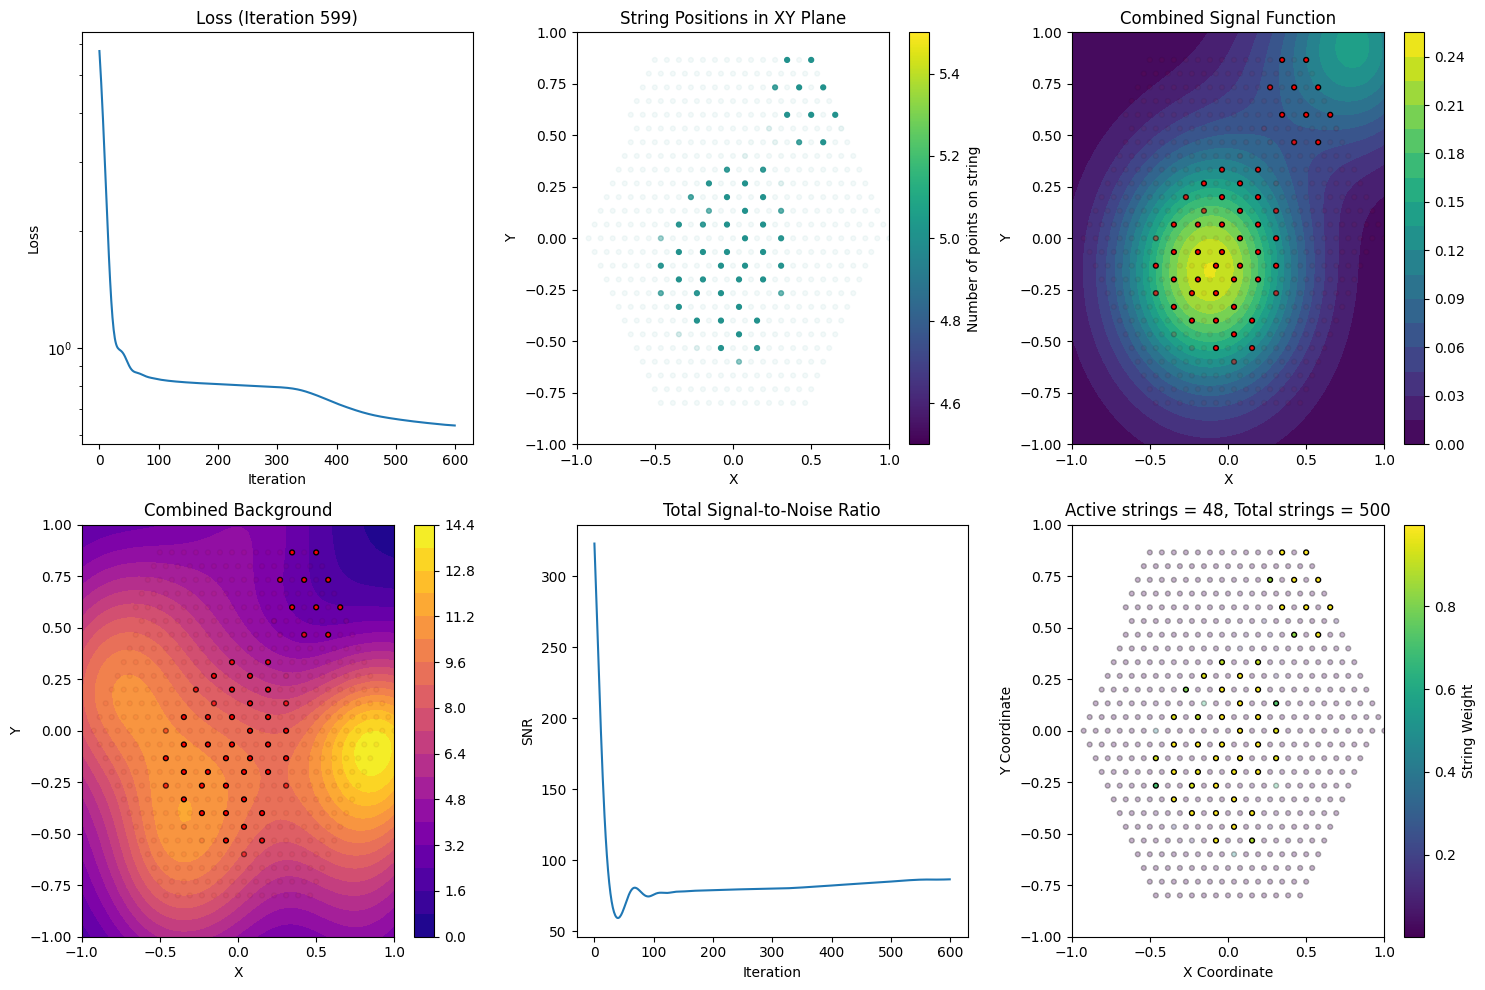

Saved GIF frame 121 to ./gif_temp/frame_0719.png


In [49]:
visualize_every = 10
vis_gif_every = 5
plot_types=["loss", "string_xy", "signal_contour", "background_contour",  "snr_history", "string_weights_scatter"]
make_gif=True
gif_plot_selection=plot_types
gif_fps=10

gif_filename='notebook_evanescent_optimization.gif'
print(f"Starting optimization with {num_iterations} iterations...")
for iteration in range(num_iterations):
    for optimizer in optimizers.values():
        optimizer.zero_grad()
    loss, avg_snr, snr_per_string = loss_function(
                        points_3d=geom_dict.get('points'),
                        signal_funcs=all_signal_funcs,
                        background_funcs=background_funcs,
                        num_strings=geometry.n_strings,
                        precomputed_snr_per_string=precomputed_snr_per_string,
                        **geom_dict
                    )
    if conflict_free:
        # Handle multiple loss components with ConFIG
        grads = []
        total_loss = 0
        
        # Clear gradients first
        for optimizer in optimizers.values():
            optimizer.zero_grad()
        
        # Compute gradients for each loss component separately
        for loss_fn in loss:
            total_loss += loss_fn.item()
            
            # Compute gradients for this loss component
            loss_fn.backward(retain_graph=True)
            
            # Extract gradients manually for string_weights
            if string_weights.grad is not None:
                grad_vector = string_weights.grad.view(-1).clone()
                grads.append(grad_vector)
            
            # Clear gradients for next loss component
            string_weights.grad = None
        
        # Calculate conflict-free gradient direction
        if len(grads) > 0:
            g_config = ConFIG_update(grads)
            
            # Apply conflict-free gradients to string_weights manually
            string_weights.grad = g_config.view_as(string_weights)
        
        # Update parameters
        for optimizer in optimizers.values():
            optimizer.step()
            
        loss_history.append(total_loss)
    else:
        loss.backward()
        for optimizer in optimizers.values():
            optimizer.step()
        loss_history.append(loss.item())
    snr_history.append(avg_snr)
    indices = np.random.permutation(len(all_signal_funcs))[:min(len(all_signal_funcs), 200)]
    vis_signal_funcs = [all_signal_funcs[i] for i in indices]  # Keep a few for visualization
    # vis_signal_funcs = all_signal_funcs
    
    # for scheduler in schedulers.values():
    #     scheduler.step()
    geom_dict = geometry.update_points(**geom_dict)
    vis_kwargs = {
        'signal_funcs': vis_signal_funcs,
        'background_funcs': background_funcs, 
        'optimize_params': optimize_params,
        'param_values': surrogate_model.param_values,
        'vis_all_signals': True,
        'all_snr': None,
        'no_background': False,
        'background_scale': 10,
        'snr_per_string': snr_per_string,
        'string_weights': torch.sigmoid(geom_dict.get('string_weights', None)).detach().cpu().numpy(),
        'num_strings': geometry.n_strings,
        'snr_history': snr_history,
        }
    additional_metrics = {
                'string_indices': geom_dict.get('string_indices'),
                'snr_history': snr_history
                    }
    if visualize_every > 0 and (iteration % visualize_every == 0 or iteration == num_iterations - 1):                                                                                                                                                       
        visualizer.visualize_progress(
        iteration=iteration,
        points_3d=geom_dict.get('points'),
        loss_history=loss_history,
        additional_metrics=additional_metrics,
        string_indices=geom_dict.get('string_indices'),
        points_per_string_list=geom_dict.get('points_per_string_list'),
        string_xy=geom_dict.get('string_xy'),
        slice_res=50,
        multi_slice=True,
        loss_type='weighted_snr',
        string_logits=geom_dict.get('string_logits'),
        plot_types=plot_types,
        **vis_kwargs
                )

    if make_gif and (iteration % vis_gif_every == 0 or iteration == num_iterations - 1):
        visualizer.visualize_progress(
            iteration=iteration,
            points_3d=geom_dict.get('points'),
            loss_history=loss_history,
            additional_metrics=additional_metrics,
            string_indices=geom_dict.get('string_indices'),
            points_per_string_list=geom_dict.get('points_per_string_list'),
            string_xy=geom_dict.get('string_xy'),
            slice_res=50,
            multi_slice=True,
            loss_type='weighted_snr',
            string_logits=geom_dict.get('string_logits'),
            plot_types=plot_types,
            make_gif=True,
            save_individual_images=True,
            compile_gif_on_iteration=False,
        
            # gif_filename=gif_filename,
            # gif_fps=gif_fps,
            gif_plot_selection=gif_plot_selection,
            **vis_kwargs
        )


In [50]:
visualizer.finalize_gif(
    gif_filename=gif_filename,
    gif_fps=gif_fps,
    cleanup_images=False)

Successfully compiled GIF 'notebook_evanescent_optimization.gif' with 121 frames.


True

In [ ]:
# visualizer.cleanup_gif_temp_files()

Cleaned up temporary directory: ./gif_temp
GIF temporary files cleanup completed.


In [ ]:
print("="*60)
print("COMPARING OPTIMIZED GEOMETRY WITH HEXAGONAL BASELINE")
print("="*60)

# Get final optimized weights and count active strings
final_weights = torch.sigmoid(geom_dict.get('string_weights', None))
active_mask = final_weights > 0.7
n_active_strings = torch.sum(active_mask).item()
print(f"Number of active strings (sigmoid > 0.7): {n_active_strings}")
print(f"Total strings: {geometry.n_strings}")
print(f"Active string percentage: {n_active_strings/geometry.n_strings*100:.1f}%")
eval_weights = torch.ones(len(final_weights)) * 5.0  # High weight for evaluation
eval_weights[~active_mask] = -5  # Set inactive strings to zero weight
# Evaluate final loss of optimized geometry
final_loss, final_avg_snr, final_snr_per_string = loss_function(
    points_3d=geom_dict.get('points'),
    signal_funcs=all_signal_funcs,
    background_funcs=background_funcs,
    num_strings=geometry.n_strings,
    precomputed_snr_per_string=precomputed_snr_per_string,
    string_xy=geom_dict.get('string_xy'),
    string_weights=eval_weights,
    points_per_string_list=geom_dict.get('points_per_string_list'),
    string_indices=geom_dict.get('string_indices')
)

if isinstance(final_loss, list):
    optimized_total_loss = sum([loss.item() for loss in final_loss])
else:
    optimized_total_loss = final_loss.item()

print(f"\nOptimized geometry results:")
print(f"  Total loss: {optimized_total_loss:.6f}")
print(f"  Average SNR: {final_avg_snr:.6f}")

# Create hexagonal baseline geometry with same number of active strings
print(f"\nCreating hexagonal baseline with {n_active_strings} strings...")

# Create hexagonal grid for string positions
geometry.dim=2
hex_positions = geometry.create_uniform_hexagonal_grid(n_active_strings)
geometry.dim=3

# Create new geometry dict for hexagonal baseline
hex_geom_dict = {
    'string_xy': hex_positions,
    'string_weights': torch.ones(n_active_strings, device=geometry.device) * 5.0,  # High weight (sigmoid ≈ 1)
    'points_per_string_list': [geometry.points_per_string] * n_active_strings,
    'string_indices': []
}

# Generate points for hexagonal geometry
current_idx = 0
hex_points = []
for i in range(n_active_strings):
    string_center = hex_positions[i]
    
    # Generate points along the string (same as original geometry)
    if geometry.dim == 3:
        z_values = torch.linspace(-geometry.domain_size/2, geometry.domain_size/2, 
                                geometry.points_per_string, device=geometry.device)
        for z in z_values:
            point = torch.cat([string_center, z.unsqueeze(0)])
            hex_points.append(point)
            hex_geom_dict['string_indices'].append(i)
    else:
        # For 2D case
        for j in range(geometry.points_per_string):
            y_offset = (j - geometry.points_per_string/2) * 0.1  # Small offset along y
            point = torch.tensor([string_center[0], string_center[1] + y_offset], device=geometry.device)
            hex_points.append(point)
            hex_geom_dict['string_indices'].append(i)

hex_geom_dict['points'] = torch.stack(hex_points)

# Evaluate hexagonal baseline
print("Evaluating hexagonal baseline...")
hex_loss, hex_avg_snr, hex_snr_per_string = loss_function(
    points_3d=hex_geom_dict['points'],
    signal_funcs=all_signal_funcs,
    background_funcs=background_funcs,
    num_strings=n_active_strings,
    string_xy=hex_geom_dict['string_xy'],
    string_weights=hex_geom_dict['string_weights'],
    points_per_string_list=hex_geom_dict['points_per_string_list'],
    string_indices=hex_geom_dict['string_indices']
)

if isinstance(hex_loss, list):
    hex_total_loss = sum([loss.item() for loss in hex_loss])
else:
    hex_total_loss = hex_loss.item()

print(f"\nHexagonal baseline results:")
print(f"  Total loss: {hex_total_loss:.6f}")
print(f"  Average SNR: {hex_avg_snr:.6f}")

# Compare results
print(f"\n" + "="*40)
print("COMPARISON RESULTS")
print("="*40)
print(f"Loss improvement: {hex_total_loss - optimized_total_loss:.6f}")
print(f"Loss ratio (hex/optimized): {hex_total_loss / optimized_total_loss:.3f}")
print(f"SNR improvement: {final_avg_snr - hex_avg_snr:.6f}")
print(f"SNR ratio (optimized/hex): {final_avg_snr / hex_avg_snr:.3f}")

if optimized_total_loss < hex_total_loss:
    improvement_pct = ((hex_total_loss - optimized_total_loss) / hex_total_loss) * 100
    print(f"✅ Optimized geometry is {improvement_pct:.1f}% better than hexagonal baseline")
else:
    degradation_pct = ((optimized_total_loss - hex_total_loss) / hex_total_loss) * 100
    print(f"❌ Optimized geometry is {degradation_pct:.1f}% worse than hexagonal baseline")



COMPARING OPTIMIZED GEOMETRY WITH HEXAGONAL BASELINE
Number of active strings (sigmoid > 0.7): 46
Total strings: 500
Active string percentage: 9.2%
weighted snr: 0.24619676172733307
String repulsion penalty: 0.009876270778477192
String number penalty: 0.0012383045395836234
String weights penalty: 0.14937743544578552
Total loss: 0.40668877959251404

Optimized geometry results:
  Total loss: 0.406689
  Average SNR: 81.235840

Creating hexagonal baseline with 46 strings...
Evaluating hexagonal baseline...
SNR per string: tensor([0.5211, 0.6039, 0.6358, 0.4229, 0.6570, 0.6166, 0.3373, 0.6232, 0.8764,
        0.6331, 0.3621, 0.2008, 0.4220, 0.8149, 0.9735, 0.8083, 0.4292, 0.1738,
        0.2226, 0.4206, 0.7868, 0.7543, 0.5765, 0.3817, 0.1734, 0.0767, 0.1806,
        0.4672, 0.8998, 1.1798, 1.1649, 0.9032, 0.5316, 0.2571, 0.0843, 0.0493,
        0.1641, 0.1891, 0.4316, 0.5546, 0.5593, 0.5021, 0.4053, 0.2152, 0.0765,
        0.0251])
weighted snr: 0.4377121329307556
String repulsion penalty: 

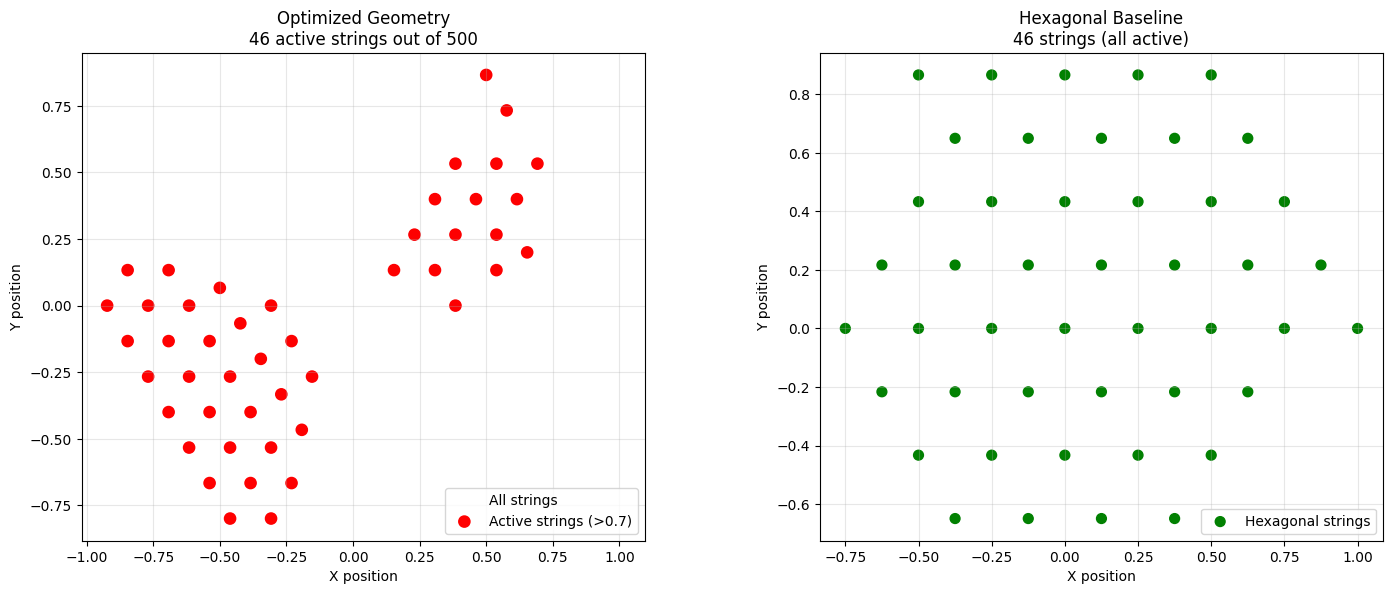

Visual comparison summary:
- Optimized geometry uses 46 active strings distributed non-uniformly
- Hexagonal baseline uses 46 strings in a regular hexagonal pattern
- Alpha transparency shows string weights (higher alpha = higher weight)
- Red dots in optimized plot show active strings (sigmoid > 0.7)


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create side-by-side plots of both geometries
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot optimized geometry
optimized_string_xy = geom_dict.get('string_xy').detach().cpu().numpy()
optimized_weights_sigmoid = torch.sigmoid(geom_dict.get('string_weights')).detach().cpu().numpy()

# Only plot active strings (sigmoid > 0.7) in optimized geometry
active_indices = optimized_weights_sigmoid > 0.7
active_xy = optimized_string_xy[active_indices]
active_alphas = optimized_weights_sigmoid[active_indices]

# Plot all strings with their actual alpha values
scatter1 = ax1.scatter(optimized_string_xy[:, 0], optimized_string_xy[:, 1], 
                      c='blue', alpha=optimized_weights_sigmoid, s=50, 
                      label='All strings')
# Highlight active strings with a border
ax1.scatter(active_xy[:, 0], active_xy[:, 1], 
           c='red', alpha=active_alphas, s=50, edgecolor='red', linewidth=2,
           label=f'Active strings (>{0.7:.1f})')

ax1.set_title(f'Optimized Geometry\n{len(active_xy)} active strings out of {len(optimized_string_xy)}')
ax1.set_xlabel('X position')
ax1.set_ylabel('Y position')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_aspect('equal')

# Plot hexagonal baseline geometry
hex_string_xy = hex_geom_dict['string_xy'].detach().cpu().numpy()
hex_weights_sigmoid = torch.sigmoid(hex_geom_dict['string_weights']).detach().cpu().numpy()

scatter2 = ax2.scatter(hex_string_xy[:, 0], hex_string_xy[:, 1], 
                      c='green', alpha=hex_weights_sigmoid, s=50,
                      label='Hexagonal strings')

ax2.set_title(f'Hexagonal Baseline\n{len(hex_string_xy)} strings (all active)')
ax2.set_xlabel('X position')
ax2.set_ylabel('Y position')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_aspect('equal')

plt.tight_layout()
# plt.suptitle('Geometry Comparison: String Positions with Sigmoid Weights as Alpha', 
            #  fontsize=14, y=1.02)
plt.show()

# Additional statistics plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of sigmoid weights for optimized geometry
# ax1.hist(optimized_weights_sigmoid, bins=30, alpha=0.7, color='blue', 
#          label='All strings', density=True)
# ax1.hist(active_alphas, bins=20, alpha=0.7, color='red', 
#          label=f'Active strings (>{0.7:.1f})', density=True)
# ax1.axvline(x=0.7, color='black', linestyle='--', label='Active threshold')
# ax1.set_xlabel('Sigmoid Weight')
# ax1.set_ylabel('Density')
# ax1.set_title('Optimized Geometry: Weight Distribution')
# ax1.legend()
# ax1.grid(True, alpha=0.3)

# # Histogram of sigmoid weights for hexagonal baseline
# ax2.hist(hex_weights_sigmoid, bins=20, alpha=0.7, color='green', 
#          label='Hexagonal strings', density=True)
# ax2.set_xlabel('Sigmoid Weight')
# ax2.set_ylabel('Density')
# ax2.set_title('Hexagonal Baseline: Weight Distribution')
# ax2.legend()
# ax2.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

print(f"Visual comparison summary:")
print(f"- Optimized geometry uses {len(active_xy)} active strings distributed non-uniformly")
print(f"- Hexagonal baseline uses {len(hex_string_xy)} strings in a regular hexagonal pattern")
print(f"- Alpha transparency shows string weights (higher alpha = higher weight)")
print(f"- Red dots in optimized plot show active strings (sigmoid > 0.7)")
# print(f"- Loss improvement: {improvement_pct:.1f}% better than hexagonal baseline")

SNR per string: tensor([1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811,
        1.5811])
weighted SNR: 0.10067378729581833
String repulsion penalty: 7.418593406677246
String number penalty: 3.9733231949096784e-18
String weights penalty: 0.9966479539871216
Total loss: 8.515914916992188
SNR per string: tensor([1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811,
        1.5811])
weighted SNR: 0.10067378729581833
String repulsion penalty: 11.346921920776367
String number penalty: 3.9733231949096784e-18
String weights penalty: 0.9966479539871216
Total loss: 12.444243431091309
SNR per string: tensor([1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.5811,
        1.5811])
weighted SNR: 0.10067378729581833
String repulsion penalty: 1.4452303647994995
String number penalty: 3.9733231949096784e-18
String weights penalty: 0.9966479539871216
Total loss: 2.5425519943237305
SNR per string: tensor([1.5811, 1.5811, 1.5811, 1.5811, 1.5811, 1.

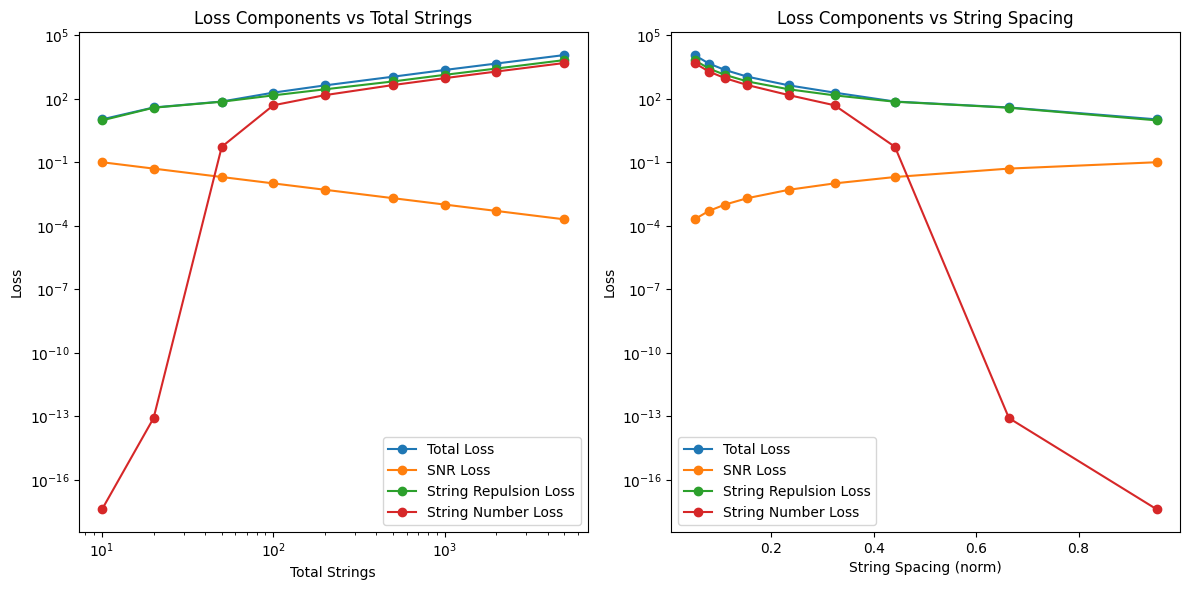

In [85]:
def test_signal_func(position):
    """Example signal function for testing."""
    return torch.ones(position.shape[0])

def test_background_func(position):
    return torch.ones(position.shape[0])

test_loss_function = nugget.utils.losses.WeightedSNRLoss(
        device=geometry.device,
        domain_size=geometry.domain_size,
        repulsion_weight=0,
        boundary_weight=0,
        string_repulsion_weight=1,
        max_local_rad=0.5,
        path_repulsion_weight=0,
        z_repulsion_weight=0,
        eva_weight=1,
        eva_boundary_weight=0,
        eva_binary_weight=0.000,
        eva_string_num_weight=1,
        eva_min_num_strings=50,
        min_dist=0.001,
        snr_weight=1,
        signal_scale=1,
        background_scale=10,
        no_background=False,
        conflict_free=True,
        )

string_spacings =[]
eva_losses = []
eva_snr_losses = []
string_repulsion_losses = []
string_num_losses = []
total_losses = []
string_num_tests =  [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
num_tests = 20
for n_active_strings in string_num_tests:
    temp_eva_loss = 0
    temp_eva_snr_loss = 0
    temp_string_repulsion_loss = 0
    temp_string_num_loss = 0
    temp_string_spacing = 0
    temp_total_loss = 0
    for _ in range(num_tests):
        
        # geometry.dim=2
        # hex_positions = geometry.create_uniform_hexagonal_grid(n_active_strings)
        # geometry.dim=3
        # create randomly placed points
        hex_positions = torch.randn(n_active_strings, 2, device=geometry.device) * geometry.domain_size / 2

        # Create new geometry dict for hexagonal baseline
        hex_geom_dict = {
            'string_xy': hex_positions,
            'string_weights': torch.ones(n_active_strings, device=geometry.device) * 5.0,  # High weight (sigmoid ≈ 1)
            'points_per_string_list': [geometry.points_per_string] * n_active_strings,
            'string_indices': []
        }

        # Generate points for hexagonal geometry
        current_idx = 0
        hex_points = []
        
        for i in range(n_active_strings):
            string_center = hex_positions[i]
            
            # Generate points along the string (same as original geometry)
            if geometry.dim == 3:
                z_values = torch.linspace(-geometry.domain_size/2, geometry.domain_size/2, 
                                        geometry.points_per_string, device=geometry.device)
                for z in z_values:
                    point = torch.cat([string_center, z.unsqueeze(0)])
                    hex_points.append(point)
                    hex_geom_dict['string_indices'].append(i)
            else:
                # For 2D case
                for j in range(geometry.points_per_string):
                    y_offset = (j - geometry.points_per_string/2) * 0.1  # Small offset along y
                    point = torch.tensor([string_center[0], string_center[1] + y_offset], device=geometry.device)
                    hex_points.append(point)
                    hex_geom_dict['string_indices'].append(i)

        hex_geom_dict['points'] = torch.stack(hex_points)

        # Evaluate hexagonal baseline
        # print("Evaluating hexagonal baseline...")
        hex_loss, hex_avg_snr, hex_snr_per_string = test_loss_function(
            points_3d=hex_geom_dict['points'],
            signal_funcs=[test_signal_func],
            background_funcs=[test_background_func],
            num_strings=n_active_strings,
            string_xy=hex_geom_dict['string_xy'],
            string_weights=hex_geom_dict['string_weights'],
            points_per_string_list=hex_geom_dict['points_per_string_list'],
            string_indices=hex_geom_dict['string_indices']
        )
        # total_losses.append(sum([l.item() for l in hex_loss]))
        # string_space = hex_geom_dict['string_xy'][0].detach().cpu().numpy() - hex_geom_dict['string_xy'][1].detach().cpu().numpy()
        # string_spacings.append(np.linalg.norm(string_space))
        # eva_snr_losses.append(hex_loss[0].item())
        # eva_losses.append(hex_loss[3].item())
        # string_repulsion_losses.append(hex_loss[1].item())
        # string_num_losses.append(hex_loss[2].item())
        temp_string_repulsion_loss += hex_loss[1].item()
        temp_eva_snr_loss += hex_loss[0].item()
        temp_eva_loss += hex_loss[3].item()
        temp_string_num_loss += hex_loss[2].item()
        temp_total_loss += sum([l.item() for l in hex_loss])
        
        # Calculate average string spacing
        # Calculate distances to only the 3 nearest neighbors for each point
        if n_active_strings > 1:
            distances = []
            for i in range(n_active_strings):
            # Calculate distances to all other strings
                dists = []
                for j in range(n_active_strings):
                    if i != j:
                        dist = torch.norm(hex_positions[i] - hex_positions[j])
                        dists.append(dist.item())
            
            # Sort distances and take only the 3 nearest (or less if fewer strings)
                dists.sort()
                nearest_count = min(3, len(dists))
                distances.extend(dists[:nearest_count])
            
            if distances:
                temp_string_spacing += sum(distances) / len(distances)
            else:
                temp_string_spacing += 0.0
    

    string_spacings.append(temp_string_spacing/num_tests)
    eva_snr_losses.append(temp_eva_snr_loss/num_tests)
    eva_losses.append(temp_eva_loss/num_tests)
    string_repulsion_losses.append(temp_string_repulsion_loss/num_tests)
    string_num_losses.append(temp_string_num_loss/num_tests)
    total_losses.append(temp_total_loss/num_tests)
    
        


fig, ax = plt.subplots(1,2,figsize=(12, 6))
ax[0].plot(string_num_tests, total_losses, label='Total Loss', marker='o')
ax[0].plot(string_num_tests, eva_snr_losses, label='SNR Loss', marker='o')
ax[0].plot(string_num_tests, string_repulsion_losses, label='String Repulsion Loss', marker='o')
ax[0].plot(string_num_tests, string_num_losses, label='String Number Loss', marker='o')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Total Strings')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Components vs Total Strings')
ax[0].legend()

ax[1].plot(string_spacings, total_losses, label='Total Loss', marker='o')
ax[1].plot(string_spacings, eva_snr_losses, label='SNR Loss', marker='o')
ax[1].plot(string_spacings, string_repulsion_losses, label='String Repulsion Loss', marker='o')
ax[1].plot(string_spacings, string_num_losses, label='String Number Loss', marker='o')
ax[1].set_yscale('log')
ax[1].set_xlabel('String Spacing (norm)')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Components vs String Spacing')
ax[1].legend()
plt.tight_layout()
plt.show()

    

In [6]:
class MLPClassifier(torch.nn.Module):
    """
    Multi-Layer Perceptron for binary classification
    
    Input: (x, y, z, light_yield) -> 4D feature vector
    Output: signal label (0 = background, 1 = signal)
    """
    def __init__(self, input_dim=4, hidden_dims=[128, 64, 32], dropout_prob=0.2):
        super(MLPClassifier, self).__init__()
        
        layers = []
        current_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(torch.nn.Linear(current_dim, hidden_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout_prob))
            # layers.append(torch.nn.BatchNorm1d(hidden_dim))
            current_dim = hidden_dim
        
        # Output layer with sigmoid activation
        layers.append(torch.nn.Linear(current_dim, 1))
        layers.append(torch.nn.Sigmoid())

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
    def predict_log_likelihood_ratio(self, x):
        """
        Compute log(p/(1-p)) where p is the network output
        This approximates the log likelihood ratio
        """
        p = self.forward(x)
        # Clamp to avoid numerical issues
        p = torch.clamp(p, 1e-7, 1 - 1e-7)
        return torch.log(p / (1 - p))

In [7]:
def generate_training_data(background_funcs, signal_funcs, signal_scale=1.0, background_scale=10.0,
                          n_samples=10000, noise_std=0.1, dim=3, device='cpu', domain_size=2.0):
    """
    Generate training data by sampling from the surrogate functions
    
    Parameters:
    -----------
    background_funcs : list
        Background function components
    signal_funcs : list
        Signal function components
    n_samples : int
        Number of samples to generate for each class
    noise_std : float
        Standard deviation for Gaussian noise added to the function values
        
    Returns:
    --------
    X : torch.Tensor
        Feature matrix (position + light_yield)
    y : torch.Tensor
        Labels (0 = background, 1 = signal)
    """
    # Generate random 3D positions
    positions = torch.rand(2 * n_samples, dim, device=device) * \
                domain_size - domain_size / 2.0  # Scale to [-domain_size/2, domain_size/2]

    # Split positions for background and signal
    bg_positions = positions[:n_samples]
    sig_positions = positions[n_samples:]
    
    # Evaluate background function at background positions
    bg_light_yield = torch.zeros(n_samples, device=device)
    for bg_func in background_funcs:
        bg_light_yield += bg_func(bg_positions)
    bg_light_yield /= len(background_funcs)  # Average over all background functions
    bg_light_yield *= background_scale  # Scale background light yield
    # Add Gaussian noise
    bg_light_yield += torch.randn_like(bg_light_yield) * noise_std
    bg_light_yield = torch.clamp(bg_light_yield, min=0)  # Ensure non-negative
    
    # Evaluate signal function at signal positions
    sig_light_yield = torch.zeros(n_samples, device=device)
    for sig_func in signal_funcs:
        sig_light_yield += sig_func(sig_positions)
    sig_light_yield /= len(signal_funcs)  # Average over all signal functions
    sig_light_yield *= signal_scale  # Scale signal light yield
    # Add Gaussian noise
    sig_light_yield += torch.randn_like(sig_light_yield) * noise_std
    sig_light_yield = torch.clamp(sig_light_yield, min=0)  # Ensure non-negative
    
    # Combine features: [x, y, z, light_yield]
    bg_features = torch.cat([bg_positions, bg_light_yield.unsqueeze(1)], dim=1)
    sig_features = torch.cat([sig_positions, sig_light_yield.unsqueeze(1)], dim=1)
    
    # Combine all features and labels
    X = torch.cat([bg_features, sig_features], dim=0)
    y = torch.cat([torch.zeros(n_samples, device=device), torch.ones(n_samples, device=device)], dim=0)

    # Shuffle the data
    indices = torch.randperm(2 * n_samples, device=device)
    X = X[indices]
    y = y[indices]
    
    return X, y

In [8]:
def plot_loss_and_likelihood_comparison(losses, test_losses, epoch, model, test_positions, test_light_yields, test_labels):
    """
    Plot loss evolution and likelihood ratio comparison with labeled data points
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot 1: Loss evolution
    axes[0].clear()
    axes[0].plot(losses, 'b-', linewidth=2)
    if test_losses is not None:
        axes[0].plot(test_losses, 'r--', linewidth=2, label='Test Loss')
        axes[0].legend()
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Training Loss (Epoch {epoch})')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: NN vs True likelihood ratio scatter
    with torch.no_grad():
        test_features = torch.cat([test_positions, test_light_yields.unsqueeze(1)], dim=1)
        nn_log_ratios = model.predict_log_likelihood_ratio(test_features).squeeze().cpu().numpy()
    
    axes[1].clear()
    # Color points by true labels
    labels_cpu = test_labels.cpu().numpy()
    bg_mask = (labels_cpu == 0) & (np.abs(nn_log_ratios) < 7)  # Background points
    sig_mask = (labels_cpu == 1) & (np.abs(nn_log_ratios) < 7)
    binned_bg, bins = np.histogram(nn_log_ratios[bg_mask], bins=100, range=(-7, 7), density=True)
    binned_sig, bins= np.histogram(nn_log_ratios[sig_mask], bins=100, range=(-7, 7), density=True)
    f_vals = (bins[:-1] + bins[1:]) / 2  # Midpoints of bins
    # print(f"bin centers: {f_vals}")
    # kde_b = gaussian_kde(nn_log_ratios[bg_mask])
    # kde_s = gaussian_kde(nn_log_ratios[sig_mask])
    
    # f_vals = np.linspace(-7, 7, 1000)
    # llr_density = np.log(kde_s(f_vals) / kde_b(f_vals))
    llr_density = np.log(binned_sig/binned_bg)  
    # print(f'llr density: {llr_density}')
    axes[1].plot(f_vals, llr_density, 'k-', linewidth=2, label='LLR Density')
    axes[1].plot(f_vals, f_vals, 'r--', linewidth=1)

    # axes[0, 1].scatter(nn_log_ratios[bg_mask], np.zeros_like(nn_log_ratios[bg_mask]), 
    #                    color='blue', alpha=0.5, label='Background', s=10)
    # axes[0, 1].scatter(nn_log_ratios[sig_mask], np.zeros_like(nn_log_ratios[sig_mask]), 
    #                    color='red', alpha=0.5, label='Signal', s=10)
    axes[1].set_xlabel('NN Log Likelihood Ratio')
    axes[1].set_ylabel('Binned Density Estimate')
    axes[1].set_xlim(-5, 5)
    axes[1].set_ylim(-5, 5)
    axes[1].set_title('Log Likelihood Ratio Density Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    


In [9]:
n_train_samples = 50000
n_test_samples = 10000
noise_std = 0.1

print(f"\nGenerating {n_train_samples} training samples for each class...")
X_train, y_train = generate_training_data(background_funcs, all_signal_funcs,
                                        signal_scale=1.0, 
                                        background_scale=10.0,
                                        dim=geometry.dim,
                                        device=geometry.device,
                                        domain_size=geometry.domain_size,
                                        n_samples=n_train_samples, 
                                        noise_std=noise_std)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Background samples: {(y_train == 0).sum().item()}")
print(f"Signal samples: {(y_train == 1).sum().item()}")

# Generate test data for evaluation
print(f"\nGenerating {n_test_samples} test samples for each class...")
X_test, y_test = generate_training_data(background_funcs, all_signal_funcs,
                                        signal_scale=1.0,
                                        background_scale=10.0,
                                        dim=geometry.dim,
                                        device=geometry.device,
                                        domain_size=geometry.domain_size,
                                      n_samples=n_test_samples, 
                                      noise_std=noise_std)

# Extract positions and light yields for test data
test_positions = X_test[:, :3]  # x, y, z
test_light_yields = X_test[:, 3]  # light yield


Generating 50000 training samples for each class...
Training data shape: torch.Size([100000, 4])
Training labels shape: torch.Size([100000])
Background samples: 50000
Signal samples: 50000

Generating 10000 test samples for each class...


In [10]:
# Initialize the neural network
batch_size = 512
print("Initializing MLP classifier...")
input_dim = 4  # x, y, z, light_yield
model = MLPClassifier(input_dim=input_dim, 
                     hidden_dims=[256, 128, 64, 32, 16], 
                     dropout_prob=0.2).to(geometry.device)

# Loss function and optimizer
criterion = torch.nn.BCELoss()  # Binary Cross Entropy Loss
# decay learning rate exponentially


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

nn_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=0.95)

# Print model architecture
print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Create data loaders
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nTraining batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print("-" * 50)

Initializing MLP classifier...
Model architecture:
MLPClassifier(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=16, out_features=1, bias=True)
    (16): Sigmoid()
  )
)

Total parameters: 45,057

Training batches: 196
Test batches: 40
--------------------------------------------------


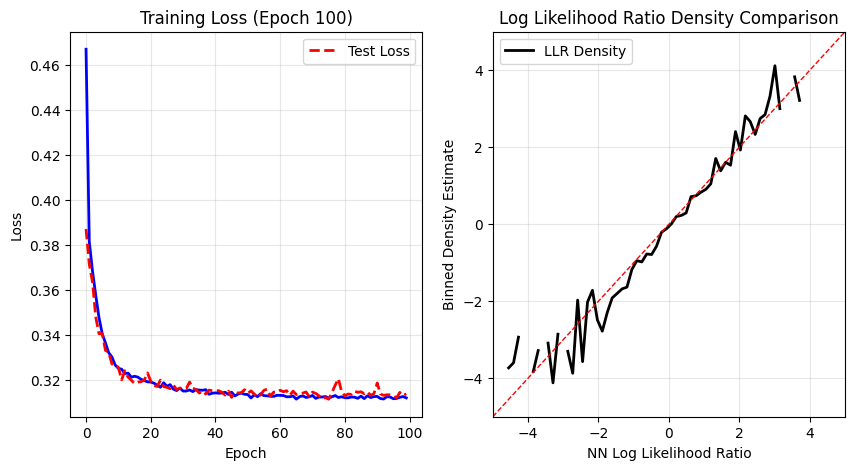

Epoch 100/100 | Loss: 0.3119 | Test Acc: 0.827 | Time: 89.4s
\nTraining completed!
Total training time: 89.5 seconds


In [11]:
# Training loop with dynamic visualization
print("Starting training...")
print("=" * 60)
num_epochs = 100
losses = []
test_losses = []
start_time = time.time()


for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    test_running_loss = 0.0
    
    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
    nn_scheduler.step()  

    # Calculate average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    test_epoch_loss = test_running_loss / len(test_loader)
    losses.append(epoch_loss)
    test_loss = criterion(model(X_test).squeeze(), y_test)

    test_losses.append(test_loss.item())
    # Evaluation phase
    if (epoch + 1) % 10 == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            # Calculate test accuracy
            test_outputs = model(X_test).squeeze()
            test_predictions = (test_outputs > 0.5).float()
            test_accuracy = (test_predictions == y_test).float().mean().item()
            
            # Calculate correlation between NN and true likelihood ratios
            nn_log_ratios = model.predict_log_likelihood_ratio(X_test).squeeze()
            # correlation = torch.corrcoef(torch.stack([true_log_ratios, nn_log_ratios]))[0, 1].item()
        
        # # Print progress
        elapsed_time = time.time() - start_time
        # print(f"Epoch {epoch+1:3d}/{num_epochs} | "
        #       f"Loss: {epoch_loss:.4f} | "
        #       f"Test Acc: {test_accuracy:.3f} | "
        #     #   f"Correlation: {correlation:.3f} | "
        #       f"Time: {elapsed_time:.1f}s")
        
        # Clear output and plot
        clear_output(wait=True)
        
        # Create visualization
        # save_frame = config['save_gif'] and ((epoch + 1) % config['plot_every'] == 0)
        fig = plot_loss_and_likelihood_comparison(losses, test_losses, epoch + 1, model, test_positions, 
                                                test_light_yields, y_test)
        plt.show()
        # Print progress again after clearing
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Loss: {epoch_loss:.4f} | "
              f"Test Acc: {test_accuracy:.3f} | "
              f"Time: {elapsed_time:.1f}s")

print("\\nTraining completed!")
total_time = time.time() - start_time
print(f"Total training time: {total_time:.1f} seconds")

In [14]:
llr_geometry = nugget.utils.geometries.EvanescentString(
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        dim=3,
        domain_size=2.0,
        n_strings=500,
        points_per_string=5,
        optimize_z=False,
        starting_weight=0.6,   
)

In [15]:
conflict_free = False
llr_loss_function = nugget.utils.losses.WeightedSNRLoss(
        device=llr_geometry.device,
        domain_size=llr_geometry.domain_size,
        repulsion_weight=0,
        boundary_weight=0,
        string_repulsion_weight=0.02,
        max_local_rad=0.08,
        path_repulsion_weight=0,
        z_repulsion_weight=0,
        eva_weight=0.9,
        eva_boundary_weight=0,
        eva_binary_weight=0.000,
        eva_string_num_weight=0.005,
        eva_min_num_strings=50,
        min_dist=0.001,
        snr_weight=40,
        signal_scale=1,
        background_scale=10,
        no_background=False,
        conflict_free=conflict_free,
        use_llr=True,
        llr_model=model,
        llr_noise = noise_std,
        print_loss=False,
        num_bkg_samples=1000,
        num_signal_samples=100,
        
)

In [16]:
llr_visualizer = nugget.utils.vis_tools.Visualizer(
                                device=llr_geometry.device,
                                dim=llr_geometry.dim, 
                                domain_size=llr_geometry.domain_size
        )

In [17]:
llr_geom_dict = llr_geometry.initialize_points()
llr_loss_history = []
llr_snr_history = []
llr_optimizers = {}
llr_schedulers = {}
num_iterations = 200
batch_size = 2

llr_string_xy = llr_geom_dict.get('string_xy')
llr_string_weights = llr_geom_dict.get('string_weights')

# print(f"Optimizing string_xy with shape {string_xy.shape}")
# string_xy.requires_grad_(True)
# geom_dict['string_xy'] = string_xy
# xy_optimizer = torch.optim.Adam([string_xy], lr=self.xy_learning_rate)
# optimizers['string_xy'] = xy_optimizer

# xy_scheduler = nugget.utils.schedulers.create_scheduler(
#     xy_optimizer, num_iterations,
#     'exp', {'gamma': 0.95}
# )

# schedulers['string_xy'] = xy_scheduler

print(f"Optimizing llr_string_weights with shape {llr_string_weights.shape}")
llr_string_weights.requires_grad_(True)
llr_geom_dict['string_weights'] = llr_string_weights
llr_weights_optimizer = torch.optim.Adam([llr_string_weights], lr=0.1)
llr_optimizers['string_weights'] = llr_weights_optimizer

# weights_scheduler = nugget.utils.schedulers.create_scheduler(
#     weights_optimizer, num_iterations,
#     'exp', {'gamma': 0.95}
# )

# schedulers['string_weights'] = weights_scheduler

Optimizing llr_string_weights with shape torch.Size([500])


In [18]:
llr_precomputed_snr_per_string = llr_loss_function.compute_snr_per_string(
    llr_geom_dict.get('points'), all_signal_funcs, background_funcs,
    llr_geometry.n_strings, llr_geom_dict.get('string_xy'), llr_geom_dict.get('points_per_string_list')
)
llr_precomputed_snr_per_string = llr_precomputed_snr_per_string.detach().cpu()

/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/utils/surrogates.py:479: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(sigma_front, device=self.device),
/Users/kristiantcho/My_Projects/Code_Testing/phd_stuff/nugget/nugget/utils/surrogates.py:480: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(sigma_back, device=self.device)


Expected LLR per string: tensor([1.0240, 1.2809, 1.1764, 0.8185, 0.6802, 0.9026, 1.2379, 1.2829, 1.2769,
        1.1948, 0.9854, 0.6499, 0.5604, 0.5472, 0.6471, 0.8510, 1.1184, 1.3793,
        1.3673, 1.3593, 1.2749, 1.1989, 1.1229, 1.0291, 0.7591, 0.5729, 0.5030,
        0.4905, 0.4968, 0.5335, 0.6606, 0.8538, 1.0609, 1.3350, 1.5033, 1.4065,
        1.2717, 1.6458, 1.5555, 1.4484, 1.2227, 1.0561, 1.0113, 0.8736, 0.6408,
        0.5100, 0.4764, 0.4744, 0.4632, 0.4674, 0.4937, 0.5717, 0.7121, 0.9160,
        1.0655, 1.3054, 1.5255, 1.6056, 1.5112, 1.4367, 1.5192, 1.7025, 1.6950,
        1.7447, 1.5700, 1.2745, 1.0129, 0.9747, 0.8987, 0.7062, 0.5575, 0.4757,
        0.4633, 0.4599, 0.4609, 0.4578, 0.4634, 0.4736, 0.5303, 0.6143, 0.7868,
        0.9976, 1.1058, 1.2773, 1.4821, 1.6297, 1.7528, 1.7006, 1.6625, 1.7576,
        1.7692, 1.6253, 1.5952, 1.6955, 1.7657, 1.6238, 1.3170, 1.0609, 0.8798,
        0.8906, 0.7193, 0.5973, 0.5033, 0.4649, 0.4597, 0.4554, 0.4557, 0.4560,
        0.4572,

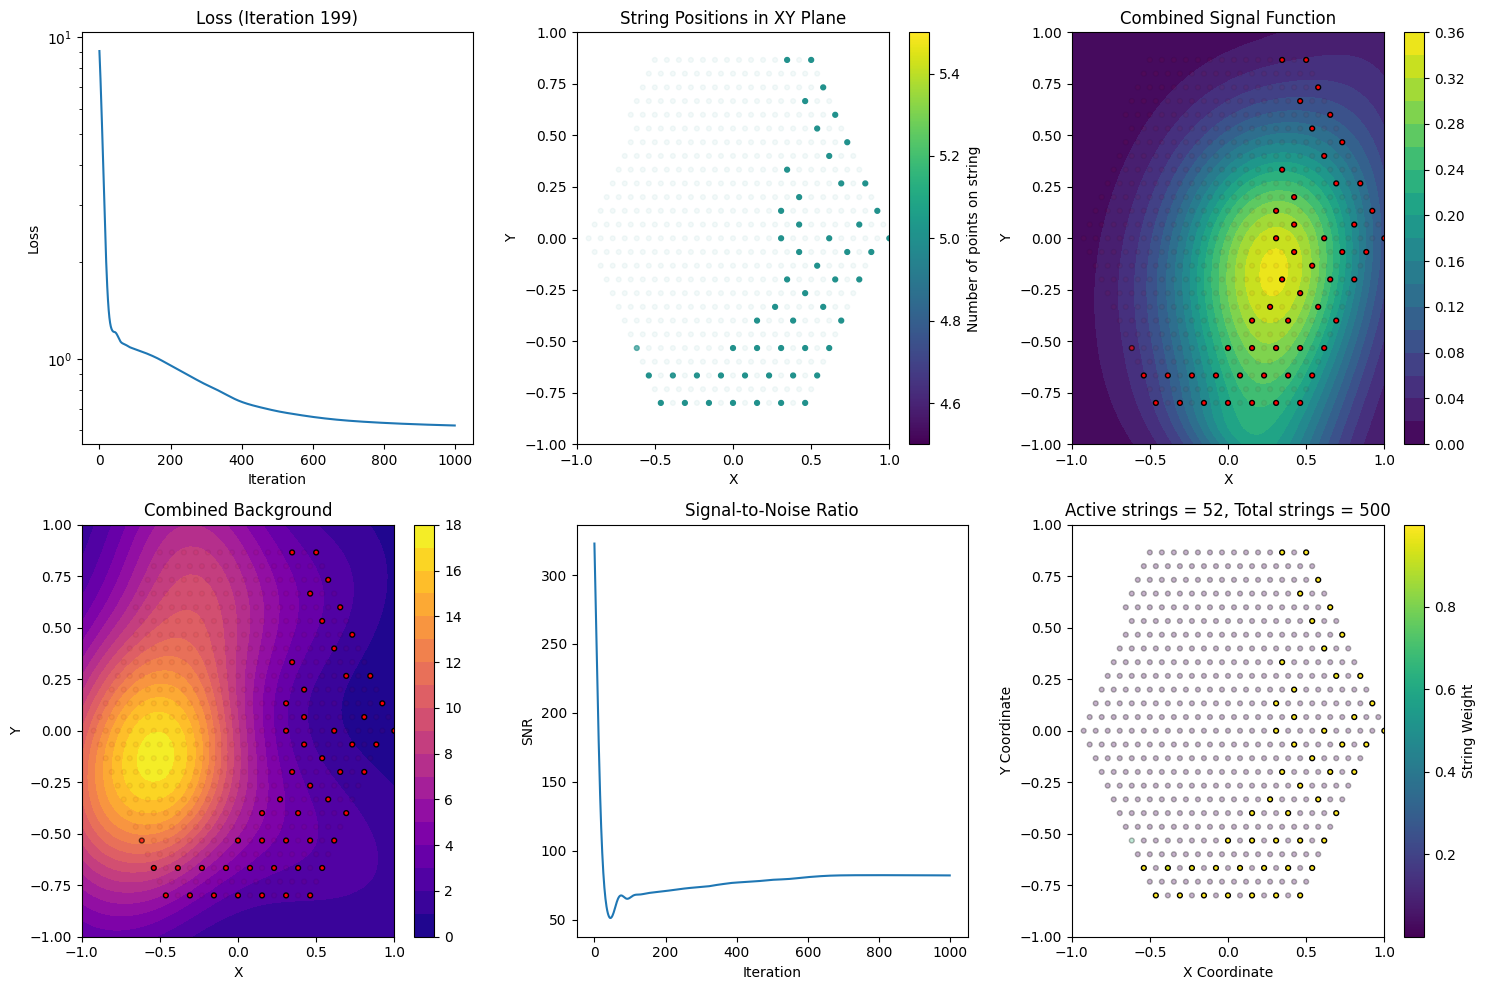

In [23]:
visualize_every = 10
plot_types=["loss", "string_xy", "signal_contour", "background_contour",  "snr_history", "string_weights_scatter"]
make_gif=False
gif_plot_selection=plot_types
gif_fps=10
gif_filename='llr_notebook_evanescent_optimization.gif'
print(f"Starting optimization with {num_iterations} iterations...")
for iteration in range(num_iterations):
    for optimizer in llr_optimizers.values():
        optimizer.zero_grad()
    loss, avg_snr, snr_per_string = llr_loss_function(
                        points_3d=llr_geom_dict.get('points'),
                        signal_funcs=all_signal_funcs,
                        background_funcs=background_funcs,
                        num_strings=llr_geometry.n_strings,
                        precomputed_snr_per_string=llr_precomputed_snr_per_string,
                        **llr_geom_dict
                    )
    if conflict_free:
        # Handle multiple loss components with ConFIG
        grads = []
        total_loss = 0
        
        # Clear gradients first
        for optimizer in llr_optimizers.values():
            optimizer.zero_grad()
        
        # Compute gradients for each loss component separately
        for loss_fn in loss:
            total_loss += loss_fn.item()
            
            # Compute gradients for this loss component
            loss_fn.backward(retain_graph=True)
            
            # Extract gradients manually for string_weights
            if llr_string_weights.grad is not None:
                grad_vector = llr_string_weights.grad.view(-1).clone()
                grads.append(grad_vector)
            
            # Clear gradients for next loss component
            llr_string_weights.grad = None

        # Calculate conflict-free gradient direction
        if len(grads) > 0:
            g_config = ConFIG_update(grads)
            
            # Apply conflict-free gradients to string_weights manually
            llr_string_weights.grad = g_config.view_as(llr_string_weights)

        # Update parameters
        for optimizer in llr_optimizers.values():
            optimizer.step()
            
        llr_loss_history.append(total_loss)
    else:
        loss.backward(retain_graph=True)
        for optimizer in llr_optimizers.values():
            optimizer.step()
        llr_loss_history.append(loss.item())
    llr_snr_history.append(avg_snr)
    indices = np.random.permutation(len(all_signal_funcs))[:min(len(all_signal_funcs), 200)]
    vis_signal_funcs = [all_signal_funcs[i] for i in indices]  # Keep a few for visualization
    # vis_signal_funcs = all_signal_funcs
    
    # for scheduler in schedulers.values():
    #     scheduler.step()
    llr_geom_dict = llr_geometry.update_points(**llr_geom_dict)
    vis_kwargs = {
        'signal_funcs': vis_signal_funcs,
        'background_funcs': background_funcs, 
        'optimize_params': optimize_params,
        'param_values': surrogate_model.param_values,
        'vis_all_signals': True,
        'all_snr': None,
        'no_background': False,
        'background_scale': 10,
        'snr_per_string': snr_per_string,
        'string_weights': torch.sigmoid(llr_geom_dict.get('string_weights', None)).detach().cpu().numpy(),
        'num_strings': llr_geometry.n_strings,
        'snr_history': llr_snr_history,
        }
    additional_metrics = {
                'string_indices': llr_geom_dict.get('string_indices'),
                'snr_history': llr_snr_history
                    }
    if visualize_every > 0 and (iteration % visualize_every == 0 or iteration == num_iterations - 1):                                                                                                                                                       
        llr_visualizer.visualize_progress(
        iteration=iteration,
        points_3d=llr_geom_dict.get('points'),
        loss_history=llr_loss_history,
        additional_metrics=additional_metrics,
        string_indices=llr_geom_dict.get('string_indices'),
        points_per_string_list=llr_geom_dict.get('points_per_string_list'),
        string_xy=llr_geom_dict.get('string_xy'),
        slice_res=50,
        multi_slice=True,
        loss_type='weighted_snr',
        string_logits=llr_geom_dict.get('string_logits'),
        plot_types=plot_types,
        **vis_kwargs
                )

    if make_gif:
        llr_visualizer.visualize_progress(
            iteration=iteration,
            points_3d=llr_geom_dict.get('points'),
            loss_history=llr_loss_history,
            additional_metrics=additional_metrics,
            string_indices=llr_geom_dict.get('string_indices'),
            points_per_string_list=llr_geom_dict.get('points_per_string_list'),
            string_xy=llr_geom_dict.get('string_xy'),
            slice_res=50,
            multi_slice=True,
            loss_type='weighted_snr',
            string_logits=llr_geom_dict.get('string_logits'),
            plot_types=plot_types,
            make_gif=True,
            gif_filename=gif_filename,
            gif_fps=gif_fps,
            gif_plot_selection=gif_plot_selection,
            **vis_kwargs
        )